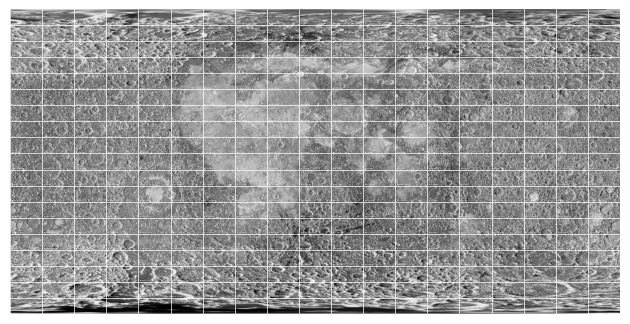

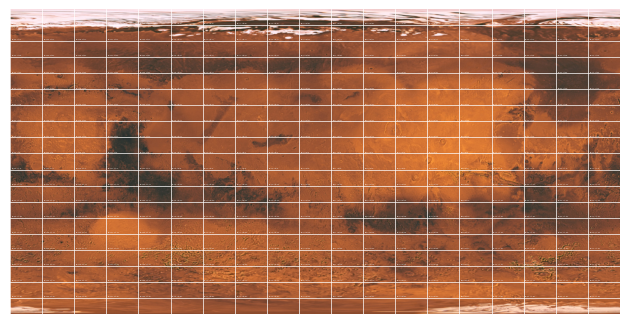

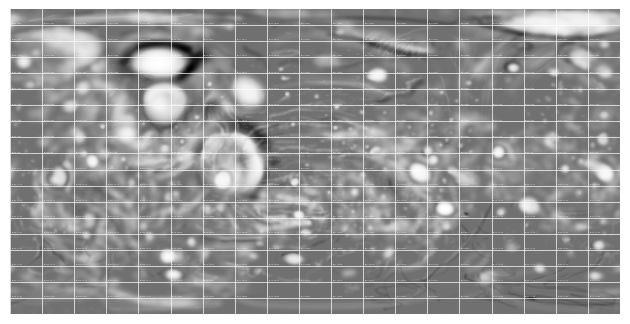

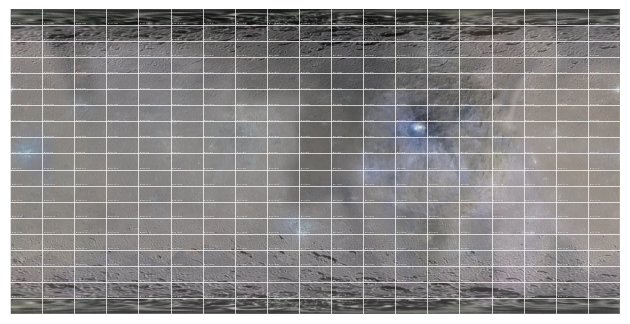

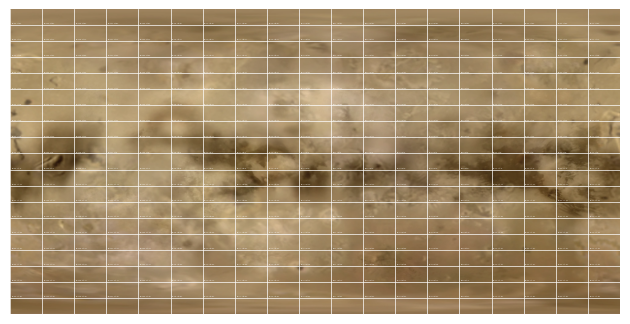

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np




def plot_grid(cel_bodies):
    def normalize_longitude(lon):
        """Normalize longitude to be within -180 to 180 degrees."""
        lon = lon - 90
        if lon > 180:
            lon -= 360
        elif lon < -180:
            lon += 360
        return -lon
    for cel_body in cel_bodies:

        img = mpimg.imread(f'images/{cel_body}.jpg')
        fig, ax = plt.subplots()
        ax.imshow(img, extent=[-180, 180, -90, 90], cmap='Greys')

        lon_values = np.linspace(-180, 180, 20)
        lat_values = np.linspace(-90, 90, 20)

     
        for lon in lon_values:
            ax.plot([lon, lon], [-90, 90], color='white', linestyle='-', linewidth=0.5)

        for lat in lat_values[1:-1]:
            ax.plot([-180, 180], [lat, lat], color='white', linestyle='-', linewidth=0.5)

        for lon in lon_values[:-1]:
            for lat in lat_values[1:-1]:
                ax.text(lon + 1, lat + 1, f"lon:{normalize_longitude(lon):.0f}°,lat:{lat:.0f}°", fontsize=0.01, color='white', ha='left', va='bottom')

       
        ax.set_xticks(np.linspace(-180, 180, 13))  
        ax.set_yticks(np.linspace(-90, 90, 7))    

        ax.set_axis_off()
        ax.set_xticks([]) 
        ax.set_yticks([])
        plt.tight_layout()
        plt.savefig(f'images/{cel_body}_with_grid.jpg', dpi=1300, bbox_inches='tight', pad_inches=0)

cel_bodies = ['moon','mars','phobos','ceres','titan']
plot_grid(cel_bodies)

In [1]:
import sqlite3
from tabulate import tabulate
import random

def create_and_fill_interplanetary_database():
    conn = sqlite3.connect('interplanetary_transport.db')
    cursor = conn.cursor()

    # Create tables
    cursor.execute("DROP TABLE IF EXISTS Celestial_Bodies")
    cursor.execute("PRAGMA foreign_keys = ON;")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Celestial_Bodies (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        type TEXT NOT NULL,
        central_body TEXT,
        central_mass REAL,
        special_features TEXT,
        description TEXT,
        mass REAL,
        radius REAL,
        orbital_period REAL,
        semi_major_axis REAL,
        eccentricity REAL,
        inclination REAL,
        mesh_path TEXT,
        initial_position_x REAL,
        initial_position_y REAL,
        initial_position_z REAL
    )
    """)


    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Locations (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        type TEXT NOT NULL,
        coordinates TEXT,
        celestial_body_id INTEGER,
        description TEXT,
        FOREIGN KEY (celestial_body_id) REFERENCES Celestial_Bodies(id)
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Elements (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        symbol TEXT NOT NULL,
        percentage REAL
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Minerals (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        formula TEXT,
        description TEXT
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Mineral_Composition (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        mineral_id INTEGER NOT NULL,
        element_id INTEGER NOT NULL,
        percentage REAL NOT NULL,
        FOREIGN KEY (mineral_id) REFERENCES Minerals(id),
        FOREIGN KEY (element_id) REFERENCES Elements(id)
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Location_Minerals (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        mineral_id INTEGER NOT NULL,
        location_id INTEGER NOT NULL,
        percentage REAL NOT NULL,
        FOREIGN KEY (mineral_id) REFERENCES Minerals(id),
        FOREIGN KEY (location_id) REFERENCES Locations(id)
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Materials_And_Intermediates (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        type TEXT NOT NULL,
        description TEXT
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Material_Composition (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        material_id INTEGER NOT NULL,
        element_id INTEGER NOT NULL,
        percentage REAL NOT NULL,
        FOREIGN KEY (material_id) REFERENCES Materials_And_Intermediates(id),
        FOREIGN KEY (element_id) REFERENCES Elements(id)
    )
    """)
    

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Products (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        type TEXT NOT NULL,
        description TEXT
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Product_Composition (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        product_id INTEGER NOT NULL,
        material_id INTEGER NOT NULL,
        quantity REAL NOT NULL,
        FOREIGN KEY (product_id) REFERENCES Products(id),
        FOREIGN KEY (material_id) REFERENCES Materials_And_Intermediates(id)
    )
    """)
    cursor.executescript("""
    CREATE TABLE IF NOT EXISTS areas (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        description TEXT,
        area_type TEXT,
        min_latitude REAL,
        max_latitude REAL,
        min_longitude REAL,
        max_longitude REAL,
        celestial_body_id INTEGER,
        FOREIGN KEY (celestial_body_id) REFERENCES celestial_bodies(id)
    );

    CREATE TABLE IF NOT EXISTS area_minerals (
        area_id INTEGER,
        mineral_id INTEGER,
        PRIMARY KEY (area_id, mineral_id),
        FOREIGN KEY (area_id) REFERENCES areas(id),
        FOREIGN KEY (mineral_id) REFERENCES minerals(id)
    );

    CREATE TABLE IF NOT EXISTS area_elements (
        area_id INTEGER,
        element_id INTEGER,
        PRIMARY KEY (area_id, element_id),
        FOREIGN KEY (area_id) REFERENCES areas(id),
        FOREIGN KEY (element_id) REFERENCES elements(id)
    );
    """)
    

    def get_id(table, name):
        cursor.execute(f"SELECT id FROM {table} WHERE name = ?", (name,))
        result = cursor.fetchone()
        return result[0] if result else None

    # Clear existing data
    tables = [
    "Product_Composition",
    "Products",
    "Material_Composition",
    "Materials_And_Intermediates",
    "Location_Minerals",
    "Mineral_Composition",
    "area_elements",
    "area_minerals",
    "areas",
    "Minerals",
    "Elements",
    "Locations",
    "Celestial_Bodies"
    ]

    for table in tables:
        cursor.execute(f"DELETE FROM {table}")

        for table in tables:
            cursor.execute(f"DELETE FROM {table}")
        
    def populate_celestial_areas(conn, areas_data, area_minerals, area_elements):
        cursor = conn.cursor()

        def get_id(table, name):
            cursor.execute(f"SELECT id FROM {table} WHERE name = ?", (name,))
            row = cursor.fetchone()
            return row[0] if row else None

        # Insert areas
        for name, desc, area_type, min_lat, max_lat, min_lon, max_lon, body_name in areas_data:
            body_id = get_id("celestial_bodies", body_name)
            if body_id:
                cursor.execute("""
                    INSERT INTO areas (
                        name, description, area_type,
                        min_latitude, max_latitude,
                        min_longitude, max_longitude,
                        celestial_body_id
                    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                """, (name, desc, area_type, min_lat, max_lat, min_lon, max_lon, body_id))

        # Link areas to minerals
        for area_name, mineral_name in area_minerals:
            cursor.execute("SELECT id FROM areas WHERE name = ?", (area_name,))
            area_row = cursor.fetchone()
            mineral_id = get_id("minerals", mineral_name)
            if area_row and mineral_id:
                cursor.execute("""
                    INSERT OR IGNORE INTO area_minerals (area_id, mineral_id)
                    VALUES (?, ?)
                """, (area_row[0], mineral_id))

        # Link areas to elements
        for area_name, element_name in area_elements:
            cursor.execute("SELECT id FROM areas WHERE name = ?", (area_name,))
            area_row = cursor.fetchone()
            element_id = get_id("elements", element_name)
            if area_row and element_id:
                cursor.execute("""
                    INSERT OR IGNORE INTO area_elements (area_id, element_id)
                    VALUES (?, ?)
                """, (area_row[0], element_id))

    # Celestial Bodies
    cursor.executemany("""
INSERT INTO Celestial_Bodies 
(name, type, central_body, central_mass, special_features, description, mass, radius, orbital_period, semi_major_axis, eccentricity, inclination, mesh_path, initial_position_x, initial_position_y, initial_position_z)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""", [
    ('Sun', 'star', None, None, 'Source of light and heat', 'Center of the solar system', 1.989e30, 696340.0, 0.0, 0.0, 0.0, 0.0, 'images/sun.jpg', 0.0, 0.0, 0.0),
    ('Earth', 'planet', 'Sun', 1.989e30, 'Blue planet', 'Home to humanity and life as we know it', 5.972e24, 6371.0, 365.25, 1.000, 0.0167, 0.0, 'images/earth.jpg', 1.0, 0.0, 0.0),
    ('Moon', 'moon', 'Earth', 5.972e24, 'Mare Imbrium, South Pole–Aitken basin', 'Rich in Helium-3 and rare earth minerals', 7.342e22, 1737.1, 27.3, 0.00257, 0.0549, 5.145, 'images/moon.jpg', 1.00257, 0.0, 0.0),
    ('Mars', 'planet', 'Sun', 1.989e30, 'Olympus Mons, Valles Marineris', 'Prime colonization target with known resources', 6.4171e23, 3389.5, 687.0, 1.523679, 0.0934, 1.85, 'images/mars.jpg', 1.5, 0.0, 0.0),
    ('Phobos', 'moon', 'Mars', 6.4171e23, 'Stickney Crater', 'Potential base for interplanetary logistics', 1.0659e16, 11.267, 0.3189, 0.000062, 0.0151, 1.093, 'images/phobos.jpg', 1.500062, 0.0, 0.0),
    ('Ceres', 'dwarf planet', 'Sun', 1.989e30, 'Occator Crater', 'Source of water and minerals', 9.393e20, 473.0, 1680.0, 2.7675, 0.0758, 10.59, 'images/ceres.jpg', 2.7, 0.0, 0.0),
    ('Titan', 'moon', 'Saturn', 5.683e26, 'Kraken Mare', 'Promising source of hydrocarbons', 1.3452e23, 2575.0, 15.945, 1.22283, 0.0288, 0.34854, 'images/titan.jpg', 9.5, 0.0, 0.0)
    ])

        # Get Moon ID
    cursor.execute("SELECT id FROM Celestial_Bodies WHERE name = 'Moon'")
    moon_id = cursor.fetchone()[0]

    # 10 Moon base locations
    moon_locations = [
        ('Artemis Base Alpha', 'lunar base', '+1.5 +23.4', moon_id, 'Main research and operations hub near the lunar equator'),
        ('Mare Tranquillitatis Outpost', 'mining site', '+0.7 +22.3', moon_id, 'Outpost near Apollo 11 landing site'),
        ('South Pole Station', 'science station', '-89.9 +45.0', moon_id, 'Perpetually shaded region rich in water ice'),
        ('Shackleton Base', 'mining base', '-89.5 +0.0', moon_id, 'Helium-3 mining location near Shackleton Crater'),
        ('Copernicus Research Hub', 'research station', '+10.0 -20.0', moon_id, 'Located on lunar highlands for geological study'),
        ('Tycho Base', 'exploration site', '-43.3 -11.2', moon_id, 'Crater rim station for geological exploration'),
        ('Mare Imbrium Camp', 'temporary outpost', '+32.8 -15.6', moon_id, 'Short-term camp near Imbrium Basin'),
        ('Highlands Ridge Base', 'science station', '+45.0 +60.0', moon_id, 'Studying crust composition at high elevation'),
        ('Far Side Relay Station', 'communication hub', '+20.0 +170.0', moon_id, 'Relay station for communication via orbiting satellites'),
        ('Luna Dome 1', 'habitat dome', '+5.0 +5.0', moon_id, 'Testbed for long-term lunar habitation')
    ]

    cursor.executemany("""
        INSERT INTO Locations (name, type, coordinates, celestial_body_id, description)
        VALUES (?, ?, ?, ?, ?)
    """, moon_locations)
    mars_locations = [
    ('Olympus Mons Base', 'research station', '+18.65 -226.2', 4, 'High-altitude station for geological and atmospheric research'),
    ('Gale Crater Habitat', 'habitat dome', '-5.4 +137.8', 4, 'Primary habitat for long-term human missions on Mars'),
    ('Valles Mining Site', 'mining site', '-7.0 -90.0', 4, 'Rich mineral deposits along the canyon system'),
    ('Elysium Research Dome', 'science station', '+25.0 147.0', 4, 'Study of volcanic plains and subsurface ice'),
    ('Utopia Planitia Shipyard', 'industrial site', '+45.0 120.0', 4, 'Spacecraft construction and maintenance'),
    ('Noctis Labyrinthus Habitat', 'habitat dome', '-4.0 -100.0', 4, 'Sheltered human settlement inside Martian valleys')
    ]
    cursor.executemany("""
        INSERT INTO Locations (name, type, coordinates, celestial_body_id, description)
        VALUES (?, ?, ?, ?, ?)
    """, mars_locations)
    
    phobos_locations = [
    ('Stickney Mining Hub', 'mining site', '+1.1 -49.0', 5, 'Regolith extraction from Stickney Crater'),
    ('Hall Outpost', 'science station', '+12.0 -40.0', 5, 'Seismology and surface composition studies'),
    ('Deimos Relay Station', 'communication hub', '+0.0 +90.0', 5, 'Relay hub between Mars orbit and Phobos'),
    ('D-Type Resources Site', 'mining site', '-2.0 +30.0', 5, 'Rare mineral extraction zone'),
    ('Orbit Control Center', 'logistics base', '+5.0 +5.0', 5, 'Support hub for Mars orbital operations')
    ]
    cursor.executemany("""
        INSERT INTO Locations (name, type, coordinates, celestial_body_id, description)
        VALUES (?, ?, ?, ?, ?)
    """, phobos_locations)
    
    ceres_locations = [
    ('Occator Science Station', 'research station', '+19.8 +239.3', 6, 'Exploration of bright spots and subsurface ice'),
    ('Ahuna Mons Outpost', 'mining base', '+10.5 +316.0', 6, 'Mining base for water ice and salt extraction'),
    ('Kerwan Crater Station', 'science base', '+11.0 +123.0', 6, 'Studies on crater formation and surface history'),
    ('Vendimia Planitia Outpost', 'research camp', '+5.0 +100.0', 6, 'Investigation of ancient cryovolcanism'),
    ('Dawn Settlement', 'habitat dome', '+20.0 +250.0', 6, 'First permanent human settlement on Ceres'),
    ('Ezinu Mining Zone', 'mining site', '-5.0 +130.0', 6, 'Extraction of ammonia-rich clays and salts')
    ]
    
    cursor.executemany("""
        INSERT INTO Locations (name, type, coordinates, celestial_body_id, description)
        VALUES (?, ?, ?, ?, ?)
    """, ceres_locations)
    
    titan_locations = [
    ('Dragonfly Operations Hub', 'exploration base', '+7.5 -199.0', 7, 'Central base for drone and rover operations'),
    ('Kraken Mare Floating Platform', 'research station', '+71.0 -225.0', 7, 'Liquid methane and ethane studies'),
    ('Shangri-La Dune Camp', 'exploration base', '-10.0 -180.0', 7, 'Study of Titan\'s vast organic dunes'),
    ('Huygens Landing Memorial', 'historical site', '-10.3 -192.3', 7, 'First human-made landing on Titan'),
    ('Tui Regio Outpost', 'science station', '-20.0 -130.0', 7, 'Organic chemistry research facility'),
    ('Sotra Patera Volcanic Base', 'research station', '-15.0 -40.0', 7, 'Investigation of possible cryovolcanic features')
    ]
    cursor.executemany("""
        INSERT INTO Locations (name, type, coordinates, celestial_body_id, description)
        VALUES (?, ?, ?, ?, ?)
    """, titan_locations)



    # Locations
    cursor.executemany("INSERT INTO Locations (name, type, coordinates, celestial_body_id, description) VALUES (?, ?, ?, ?, ?)", [
    ('Valles Marineris', 'mining region', '-7.0 -90.0', 4, 'Major canyon system with rich mineral deposits'),
    ('Stickney Crater', 'mining region', '+1.0 -49.0', 5, 'Rich in regolith and ice'),
    ('Occator', 'mining region', '+19.8 +239.3', 6, 'Deposits of salts and water ice'),
    ('Kraken Mare', 'mining region', '+71.0 -225.0', 7, 'Liquid hydrocarbon lakes')])

    # Elements
    cursor.executemany("INSERT INTO Elements (name, symbol, percentage) VALUES (?, ?, ?)", [
        ('Iron', 'Fe', 32.1),
        ('Silicon', 'Si', 15.1),
        ('Aluminum', 'Al', 1.4),
        ('Titanium', 'Ti', 0.6),
        ('Hydrogen', 'H', 0.1),
        ('Oxygen', 'O', 30.1)
    ])

    # Minerals
    cursor.executemany("INSERT INTO Minerals (name, formula, description) VALUES (?, ?, ?)", [
        ('Olivine', '(Mg,Fe)₂SiO₄', 'Primary component of Martian regolith'),
        ('Hematite', 'Fe₂O₃', 'Iron source for space construction'),
        ('Ilmenite', 'FeTiO₃', 'Important source of titanium and oxygen'),
        ('Cryolite', 'Na₃AlF₆', 'Used in aluminum production')
    ])

    # Mineral Composition
    cursor.executemany("INSERT INTO Mineral_Composition (mineral_id, element_id, percentage) VALUES (?, ?, ?)", [
        (1, 1, 25.0), (1, 2, 18.0), (1, 6, 42.0),
        (2, 1, 70.0), (2, 6, 30.0),
        (3, 1, 36.8), (3, 4, 31.6), (3, 6, 31.6),
        (4, 3, 13.0), (4, 6, 54.0)
    ])

    # Location Minerals
    cursor.executemany("INSERT INTO Location_Minerals (mineral_id, location_id, percentage) VALUES (?, ?, ?)", [
        (1, 1, 35.0), (2, 1, 15.0),
        (3, 2, 8.0), (4, 3, 5.0)
    ])

    # Materials and Intermediates
    cursor.executemany("INSERT INTO Materials_And_Intermediates (name, type, description) VALUES (?, ?, ?)", [
        ('Martian Steel', 'composite', 'Steel alloy with Martian mineral additives'),
        ('Titanium Alloy', 'composite', 'Light and durable material for spacecraft'),
        ('Aerogel', 'synthetic', 'Thermal insulation material for stations'),
        ('Lunar Concrete', 'composite', 'Construction material from lunar regolith')
    ])

    # Material Composition
    cursor.executemany("INSERT INTO Material_Composition (material_id, element_id, percentage) VALUES (?, ?, ?)", [
        (1, 1, 85.0), (1, 4, 10.0),
        (2, 4, 90.0), (2, 1, 6.0),
        (3, 2, 45.0), (3, 6, 55.0),
        (4, 2, 25.0), (4, 6, 50.0)
    ])

    # Products
    cursor.executemany("INSERT INTO Products (name, type, description) VALUES (?, ?, ?)", [
        ('Cargo Ship Hull', 'structure', 'Main structure of an interplanetary cargo ship'),
        ('Station Heat Shield', 'device', 'Radiation protection for space stations'),
        ('Mining Drone', 'tool', 'Autonomous device for resource extraction'),
        ('Orbital Farm', 'structure', 'Space station for producing materials in orbit')
    ])

    # Product Composition
    cursor.executemany("INSERT INTO Product_Composition (product_id, material_id, quantity) VALUES (?, ?, ?)", [
        (1, 2, 15),
        (2, 3, 8),
        (3, 1, 5),
        (4, 4, 20)
    ])
    cursor.execute("SELECT id, name FROM Locations")
    locations = cursor.fetchall()

    # Define a mapping of location name keywords to likely minerals
    mineral_by_keyword = {
        'mars': [1, 2],  # Olivine, Hematite
        'phobos': [3],   # Ilmenite
        'moon': [3, 4],  # Ilmenite, Cryolite
        'ceres': [4],    # Cryolite
        'titan': [],     # Hydrocarbons not modeled here
        'outpost': [1, 3],
        'base': [1, 2, 3],
        'station': [2, 4],
        'camp': [1],
        'habitat': [1, 4],
        'crater': [2, 3],
        'mons': [1],
        'ridge': [1, 2]
    }

    # Add minerals for all locations
    for loc_id, loc_name in locations:
        added_minerals = set()
        for keyword, mineral_ids in mineral_by_keyword.items():
            if keyword.lower() in loc_name.lower():
                for mineral_id in mineral_ids:
                    if mineral_id not in added_minerals:
                        percentage = round(random.uniform(5, 30), 2)
                        cursor.execute("""
                            INSERT INTO Location_Minerals (mineral_id, location_id, percentage)
                            VALUES (?, ?, ?)
                        """, (mineral_id, loc_id, percentage))
                        added_minerals.add(mineral_id)
                        
                        
                    
    moon_areas = [
    ("Northern Hemisphere - East", "Eastern region in the northern hemisphere", "region",
     0.0, 90.0, 0.0, 180.0, "Moon"),
    ("Northern Hemisphere - West", "Western region in the northern hemisphere", "region",
     0.0, 90.0, -180.0, 0.0, "Moon"),
    ("Southern Hemisphere - East", "Eastern region in the southern hemisphere", "region",
     -90.0, 0.0, 0.0, 180.0, "Moon"),
    ("Southern Hemisphere - West", "Western region in the southern hemisphere", "region",
     -90.0, 0.0, -180.0, 0.0, "Moon")
    ]

    moon_area_minerals = [
    ("Northern Hemisphere - East", "Ilmenite"),
    ("Northern Hemisphere - West", "Olivine"),
    ("Southern Hemisphere - East", "Anorthite"),
    ("Southern Hemisphere - West", "Pyroxene"),
   ]

    moon_area_elements = [
        ("Northern Hemisphere - East", "Titanium"),
        ("Southern Hemisphere - West", "Aluminum"),
        ("Southern Hemisphere - East", "Iron"),
        ("Northern Hemisphere - West", "Magnesium"),
    ]             
     
    populate_celestial_areas(conn, moon_areas, moon_area_minerals, moon_area_elements)
    
    mars_areas = [
    ("Northern Hemisphere - East", "Eastern region in the northern hemisphere of Mars", "region",
     0.0, 90.0, 0.0, 180.0, "Mars"),
    ("Northern Hemisphere - West", "Western region in the northern hemisphere of Mars", "region",
     0.0, 90.0, -180.0, 0.0, "Mars"),
    ("Southern Hemisphere - East", "Eastern region in the southern hemisphere of Mars", "region",
     -90.0, 0.0, 0.0, 180.0, "Mars"),
    ("Southern Hemisphere - West", "Western region in the southern hemisphere of Mars", "region",
     -90.0, 0.0, -180.0, 0.0, "Mars")
   ]

    mars_area_minerals = [
    ("Northern Hemisphere - East", "Hematite"),
    ("Northern Hemisphere - West", "Olivine"),
    ("Southern Hemisphere - East", "Clay minerals"),
    ("Southern Hemisphere - West", "Basalt")
    ]

    mars_area_elements = [
    ("Northern Hemisphere - East", "Iron"),
    ("Northern Hemisphere - West", "Magnesium"),
    ("Southern Hemisphere - East", "Calcium"),
    ("Southern Hemisphere - West", "Silicon")
    ]
    
    populate_celestial_areas(conn, mars_areas, mars_area_minerals, mars_area_elements)
    
    
    phobos_areas = [
    ("Northern Hemisphere - East", "Eastern region in the northern hemisphere of Phobos", "region",
     0.0, 90.0, 0.0, 180.0, "Phobos"),
    ("Northern Hemisphere - West", "Western region in the northern hemisphere of Phobos", "region",
     0.0, 90.0, -180.0, 0.0, "Phobos"),
    ("Southern Hemisphere - East", "Eastern region in the southern hemisphere of Phobos", "region",
     -90.0, 0.0, 0.0, 180.0, "Phobos"),
    ("Southern Hemisphere - West", "Western region in the southern hemisphere of Phobos", "region",
     -90.0, 0.0, -180.0, 0.0, "Phobos")
    ]
    phobos_area_minerals = [
    ("Northern Hemisphere - East", "Olivine"),
    ("Northern Hemisphere - West", "Basalt"),
    ("Southern Hemisphere - East", "Magnetite"),
    ("Southern Hemisphere - West", "Pyroxene")
    ]

    phobos_area_elements = [
    ("Northern Hemisphere - East", "Magnesium"),
    ("Northern Hemisphere - West", "Calcium"),
    ("Southern Hemisphere - East", "Iron"),
    ("Southern Hemisphere - West", "Silicon")
    ]

    
    populate_celestial_areas(conn, phobos_areas, phobos_area_minerals, phobos_area_elements)
    
    ceres_areas = [
    ("Northern Hemisphere - East", "Eastern region in the northern hemisphere of Ceres", "region",
     0.0, 90.0, 0.0, 180.0, "Ceres"),
    ("Northern Hemisphere - West", "Western region in the northern hemisphere of Ceres", "region",
     0.0, 90.0, -180.0, 0.0, "Ceres"),
    ("Southern Hemisphere - East", "Eastern region in the southern hemisphere of Ceres", "region",
     -90.0, 0.0, 0.0, 180.0, "Ceres"),
    ("Southern Hemisphere - West", "Western region in the southern hemisphere of Ceres", "region",
     -90.0, 0.0, -180.0, 0.0, "Ceres")
    ]

    ceres_area_minerals = [
        ("Northern Hemisphere - East", "Halite"),
        ("Northern Hemisphere - West", "Carbonate"),
        ("Southern Hemisphere - East", "Pyroxene"),
        ("Southern Hemisphere - West", "Anorthite")
    ]

    ceres_area_elements = [
        ("Northern Hemisphere - East", "Sodium"),
        ("Northern Hemisphere - West", "Carbon"),
        ("Southern Hemisphere - East", "Magnesium"),
        ("Southern Hemisphere - West", "Aluminum")
    ]

    populate_celestial_areas(conn, ceres_areas, ceres_area_minerals, ceres_area_elements)
    
    titan_areas = [
    ("Northern Hemisphere - East", "Eastern region in the northern hemisphere of Titan", "region",
     0.0, 90.0, 0.0, 180.0, "Titan"),
    ("Northern Hemisphere - West", "Western region in the northern hemisphere of Titan", "region",
     0.0, 90.0, -180.0, 0.0, "Titan"),
    ("Southern Hemisphere - East", "Eastern region in the southern hemisphere of Titan", "region",
     -90.0, 0.0, 0.0, 180.0, "Titan"),
    ("Southern Hemisphere - West", "Western region in the southern hemisphere of Titan", "region",
     -90.0, 0.0, -180.0, 0.0, "Titan")
    ]

    titan_area_minerals = [
        ("Northern Hemisphere - East", "Ammonia"),
        ("Northern Hemisphere - West", "Ethane"),
        ("Southern Hemisphere - East", "Water Ice"),
        ("Southern Hemisphere - West", "Methane")
    ]

    titan_area_elements = [
        ("Northern Hemisphere - East", "Nitrogen"),
        ("Northern Hemisphere - West", "Nitrogen"),
        ("Southern Hemisphere - East", "Oxygen"),
        ("Southern Hemisphere - West", "Carbon")
    ]

    
    populate_celestial_areas(conn, titan_areas, titan_area_minerals, titan_area_elements)

    conn.commit()
    

    # Display Tables
    def show_table(name):
        cursor.execute(f"SELECT * FROM {name}")
        rows = cursor.fetchall()
        headers = [desc[0] for desc in cursor.description]
        print(f"\n{name}:")
        print(tabulate(rows, headers=headers, tablefmt="grid"))

    for table in tables:
        show_table(table)

    conn.close()
create_and_fill_interplanetary_database()


Product_Composition:
+------+--------------+---------------+------------+
|   id |   product_id |   material_id |   quantity |
+======+==============+===============+============+
|    1 |            1 |             2 |         15 |
+------+--------------+---------------+------------+
|    2 |            2 |             3 |          8 |
+------+--------------+---------------+------------+
|    3 |            3 |             1 |          5 |
+------+--------------+---------------+------------+
|    4 |            4 |             4 |         20 |
+------+--------------+---------------+------------+

Products:
+------+---------------------+-----------+------------------------------------------------+
|   id | name                | type      | description                                    |
+======+=====================+===========+================================================+
|    1 | Cargo Ship Hull     | structure | Main structure of an interplanetary cargo ship |
+------+--------

In [3]:
import sqlite3
conn = sqlite3.connect("interplanetary_transport.db")
cursor = conn.cursor()
#cursor.execute('SELECT M.name, M.formula, LM.percentage FROM Location_Minerals LM JOIN Minerals M ON LM.mineral_id = M.id WHERE LM.location_id = 9')

cursor.execute(''' 
   SELECT M.name, M.formula, LM.percentage FROM Location_Minerals LM JOIN Minerals M ON LM.mineral_id = M.id WHERE LM.location_id = 55
''')
results = cursor.fetchall()

print("Results:")
for row in results:
    print(row)
conn.close()

Results:
('Olivine', '(Mg,Fe)₂SiO₄', 88.0)
('Olivine', '(Mg,Fe)₂SiO₄', 88.0)


In [10]:
import sqlite3

conn = sqlite3.connect('interplanetary_transport.db')
cursor = conn.cursor()
cursor.execute("SELECT * FROM Locations")

# Fetch all rows
rows = cursor.fetchall()

# Optional: get column names
column_names = [description[0] for description in cursor.description]
print(" | ".join(column_names))  # Print header

# Print each row
for row in rows:
    print(" | ".join(str(item) for item in row))

# Close the connection
conn.close()

id | name | type | coordinates | celestial_body_id | description
1 | Artemis Base Alpha | lunar base | +1.5 +23.4 | 3 | Main research and operations hub near the lunar equator
2 | Mare Tranquillitatis Outpost | mining site | +0.7 +22.3 | 3 | Outpost near Apollo 11 landing site
3 | South Pole Station | science station | -89.9 +45.0 | 3 | Perpetually shaded region rich in water ice
4 | Shackleton Base | mining base | -89.5 +0.0 | 3 | Helium-3 mining location near Shackleton Crater
5 | Copernicus Research Hub | research station | +10.0 -20.0 | 3 | Located on lunar highlands for geological study
6 | Tycho Base | exploration site | -43.3 -11.2 | 3 | Crater rim station for geological exploration
7 | Mare Imbrium Camp | temporary outpost | +32.8 -15.6 | 3 | Short-term camp near Imbrium Basin
8 | Highlands Ridge Base | science station | +45.0 +60.0 | 3 | Studying crust composition at high elevation
9 | Far Side Relay Station | communication hub | +20.0 +170.0 | 3 | Relay station for communicat

In [11]:
import sqlite3
conn = sqlite3.connect('interplanetary_transport.db')
cursor = conn.cursor()
cursor.execute("SELECT * FROM Location_Minerals")

# Fetch all rows
rows = cursor.fetchall()

# Optional: get column names
column_names = [description[0] for description in cursor.description]
print(" | ".join(column_names))  # Print header

# Print each row
for row in rows:
    print(" | ".join(str(item) for item in row))

# Close the connection
conn.close()

id | mineral_id | location_id | percentage
1 | 1 | 1 | 35.0
2 | 2 | 1 | 15.0
3 | 3 | 2 | 8.0
4 | 4 | 3 | 5.0
5 | 1 | 1 | 12.9
6 | 2 | 1 | 8.87
7 | 3 | 1 | 27.71
8 | 1 | 2 | 18.01
9 | 3 | 2 | 11.49
10 | 2 | 3 | 16.15
11 | 4 | 3 | 14.74
12 | 1 | 4 | 7.07
13 | 2 | 4 | 6.94
14 | 3 | 4 | 25.82
15 | 1 | 6 | 8.65
16 | 2 | 6 | 13.55
17 | 3 | 6 | 25.52
18 | 1 | 7 | 10.58
19 | 1 | 8 | 27.81
20 | 2 | 8 | 12.38
21 | 3 | 8 | 27.4
22 | 2 | 9 | 9.7
23 | 4 | 9 | 27.02
24 | 1 | 11 | 24.56
25 | 2 | 11 | 10.18
26 | 3 | 11 | 20.57
27 | 1 | 12 | 11.7
28 | 4 | 12 | 13.76
29 | 2 | 12 | 21.47
30 | 3 | 12 | 25.22
31 | 1 | 16 | 18.84
32 | 4 | 16 | 29.85
33 | 1 | 18 | 27.35
34 | 3 | 18 | 12.79
35 | 2 | 19 | 19.23
36 | 4 | 19 | 17.85
37 | 2 | 22 | 27.48
38 | 4 | 22 | 7.62
39 | 1 | 23 | 28.62
40 | 3 | 23 | 26.89
41 | 2 | 24 | 28.84
42 | 4 | 24 | 6.36
43 | 3 | 24 | 21.64
44 | 1 | 25 | 27.53
45 | 3 | 25 | 27.81
46 | 1 | 30 | 29.16
47 | 1 | 32 | 5.88
48 | 3 | 32 | 12.79
49 | 1 | 33 | 14.1
50 | 2 | 33 | 14.22
51 | 3 |